# House pricing

## General setup

In [48]:
%load_ext autoreload
%autoreload 2
%matplotlib inline

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

import warnings

from src.config import (
    MASTER_DF_FILE,
    MASTER_DF0_FILE,
    YEARS,
    RANDOM_SEED,
    CLUSTERING_CONFIGS,
    URBAN_CLUSTER_FILE,
    MODELS_DIR
)

from src.data.loader import DataLoader
from src.features.dimentionality import UrbanizationPCA
from src.models.clustering import ClusteringEngine


warnings.filterwarnings("ignore")

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


## Phase 1

### Collecting and processing data

The directory [`notebooks/eda/`](notebooks/clustering/) contains more detailed notebooks on the data cleaning, preparation and EDA. 

---

Here's the result of that work: the master dataset, that contains all of the relevant data from 2 open APIs (Weather: [OpenMeteoAPI](https://open-meteo.com/en/docs/historical-weather-api) and amenities from [OpenStreetMapAPI](https://www.openstreetmap.org/#map=7/39.606/-7.839)) and 4 datasets (all obtained from the Pordata portal):
- Average house pricing
- Average income among people with total education level
- Population density
- Age distributions

As a result of the data manipulations the master dataset was created. It contains 28 columns, where:
- 2 columns indicate the average quarter house price (regular and log of the price)
- 3 temporal columns (`quarter_num`, `quarter_ord` and `year`), one of which (`year`) is mostly a helper/meta column
- 16 amenities columns
- 1 income column
- 5 weather columns
- 1 municipality name column (meta column)

The data in the dataset describes 230 municipalities, all on the NUTS4 level, for 4 whole years + 1 quarter, from the last quarter of 2019 till the end of 2023. 

> Combining the master dataset (look for the Phase 1 section) [`notebooks/eda/04_combine_master_dataset.ipynb`](notebooks/eda/04_combine_master_dataset.ipynb)

> Data cleaning: [`notebooks/eda/00_data_cleaning.ipynb`](notebooks/eda/00_data_cleaning.ipynb) and [`notebooks/eda/03_weather_age_features.ipynb`](notebooks/eda/03_weather_age_features.ipynb) for the weather data

> Initial EDA: [`notebooks/eda/01_eda.ipynb`](notebooks/eda/01_eda.ipynb)

In [49]:
df0 = pd.read_csv(MASTER_DF0_FILE, index_col=0)
df0.head()

,municipality,house_price,total_sunshine_h,mean_sunshine_h,windspeed_mean_kmh,total_precipitation_mm,mean_precipitation_mm,year,quarter_num,quarter_ord,...,library,mall,museum,pharmacy,police,post_office,school,station,theatre,university
0,Arcos de Valdevez,813.0,487.521214,5.299144,9.177174,1405.1,15.272826,2023,4,17,...,4.0,2.0,5.0,10.0,2.0,4.0,15.0,1.0,1.0,0.0
4,Paredes de Coura,723.0,472.135439,5.131907,10.283696,1237.1,13.446739,2023,4,17,...,1.0,0.0,1.0,4.0,1.0,1.0,7.0,1.0,0.0,0.0
5,Ponte da Barca,759.0,499.030875,5.424249,8.804348,1300.5,14.135870,2023,4,17,...,3.0,2.0,7.0,10.0,2.0,3.0,16.0,1.0,1.0,0.0
6,Ponte de Lima,1128.0,513.344253,5.579829,11.211957,1132.9,12.314130,2023,4,17,...,2.0,2.0,3.0,13.0,6.0,2.0,39.0,2.0,1.0,2.0
7,Valença,945.0,549.046297,5.967895,13.494565,386.7,4.203261,2023,4,17,...,3.0,1.0,3.0,7.0,6.0,4.0,23.0,5.0,1.0,1.0


The initial assumptions from the beginning and after the initial EDA ([`notebooks/eda/01_eda.ipynb`](notebooks/eda/01_eda.ipynb)) include that the key drivers for the house pricing were income and amenities. We're also aware of the geographical specifics of Portugal, so to align with it we also considered the assumption that wind could be one the key factors, since windspeed is higher closer to the coastal line.

### Modeling

As an initial approach, we trained our models using the entire dataset with a simple 80/20 random split. 

This served as a baseline to establish a starting point for comparison. 

We experimented with several models, but the two that stood out were ElasticNet and Gradient Boosting Regressor, as they delivered the best performance. 

In the first run, we achieved an R² score above 91%. Although this seemed promising, a closer look at the actual versus predicted values revealed that the predictions were almost perfect, which seemed suspicious. After a more detailed analysis, we realized that the random split had allowed data from the same city to appear in both the training and test sets. To solve this issue, we decided to use grouped K-Fold cross-validation to ensure that each city appeared only in the training or the test data within each fold.


> 📓 Full first-phase modeling details: [`notebooks/modeling/01_modeling.ipynb`](notebooks/modeling/01_modeling.ipynb)

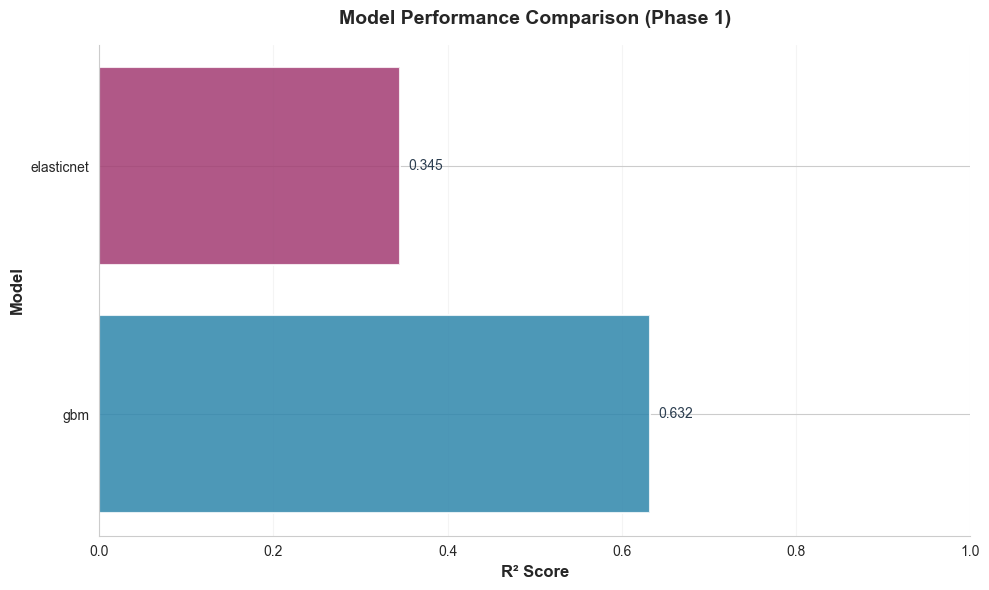

In [50]:
cv_results = pd.read_csv(MODELS_DIR / "cv_results.csv")
cv_results = cv_results[cv_results['Model'].isin(['elasticnet', 'gbm'])]

fig, ax = plt.subplots(figsize=(10, 6))
fig.patch.set_facecolor('white')

colors = ['#2E86AB', '#A23B72']
bars = ax.barh(cv_results['Model'], cv_results['Test R²'], color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)

ax.set_xlabel('R² Score', fontsize=12, fontweight='600')
ax.set_ylabel('Model', fontsize=12, fontweight='600')
ax.set_title('Model Performance Comparison (Phase 1)', fontsize=14, fontweight='bold', pad=15)
ax.set_xlim(0, 1)
ax.grid(True, alpha=0.2, axis='x')
sns.despine(ax=ax)

for bar in bars:
    width = bar.get_width()
    ax.text(width + 0.01, bar.get_y() + bar.get_height()/2, 
            f'{width:.3f}', ha='left', va='center', 
            fontsize=10, color='#2C3E50', fontweight='500')

plt.tight_layout()
plt.show()

## Phase 2

### Adding more data

With the addition of 2 datasets (age distribution and density, more detailed in [`notebooks/eda/02_eda_add.ipynb`](notebooks/eda/02_eda_add.ipynb)) and engineered features ([`notebooks/eda/03_weather_age_features.ipynb`](notebooks/eda/03_weather_age_features.ipynb)), the master dataset became fairly bigger (+ 11 features). Newly added information includes 6 age bucket columns, 1 population density column and 4 comfort weather features.

The comfort weather feature criteria were picked solely by us so the features are not really a reliale source of information. Yet we've added them in order to experiment whether the overall feature of quality of life would make a change.

In [51]:
df1 = pd.read_csv(MASTER_DF_FILE, index_col=0)
df1.head()

,municipality,house_price,total_sunshine_h,mean_sunshine_h,windspeed_mean_kmh,total_precipitation_mm,mean_precipitation_mm,windy_days,rainy_days,sunny_days,...,library,mall,museum,pharmacy,police,post_office,school,station,theatre,university
0,Arcos de Valdevez,813.0,487.521214,5.299144,9.177174,1405.1,15.272826,0,57,34,...,4.0,2.0,5.0,10.0,2.0,4.0,15.0,1.0,1.0,0.0
4,Paredes de Coura,723.0,472.135439,5.131907,10.283696,1237.1,13.446739,0,57,34,...,1.0,0.0,1.0,4.0,1.0,1.0,7.0,1.0,0.0,0.0
5,Ponte da Barca,759.0,499.030875,5.424249,8.804348,1300.5,14.135870,0,57,35,...,3.0,2.0,7.0,10.0,2.0,3.0,16.0,1.0,1.0,0.0
6,Ponte de Lima,1128.0,513.344253,5.579829,11.211957,1132.9,12.314130,2,58,38,...,2.0,2.0,3.0,13.0,6.0,2.0,39.0,2.0,1.0,2.0
7,Valença,945.0,549.046297,5.967895,13.494565,386.7,4.203261,1,54,27,...,3.0,1.0,3.0,7.0,6.0,4.0,23.0,5.0,1.0,1.0


### Clustering

The idea behind it was to try to distinguish the clusters based on the urbanization or development level of the municipality. Amenities, average income and population density were chosen to be the features to describe the urbanization level. For the vizualization the PCA was used, as a result of which 2 PCs were used. The second PC is heavily weighted on the income and density, thus it is marked as _Wealth and Density_ on the plots, while the first PC preserves the most of the variance of the infrastructure per municipality. 

Before the clustering the visualization of the data (extended master dataset, `df1`, with the selected features) was visualized yearly in order to see whether exists a significant change that would require us to perform more complex clustering analysis. The inspection of the obtained plots led us to the conclusion that we could safely pick one of the years (2020-2023) and train the KMeans model in order to retrieve the cluster label that we could later expand on the whole dataset. 

>  Full clustering story: [`notebooks/clustering/01_urbanization_clustering_all.ipynb`](notebooks/clustering/01_urbanization_clustering_all.ipynb)

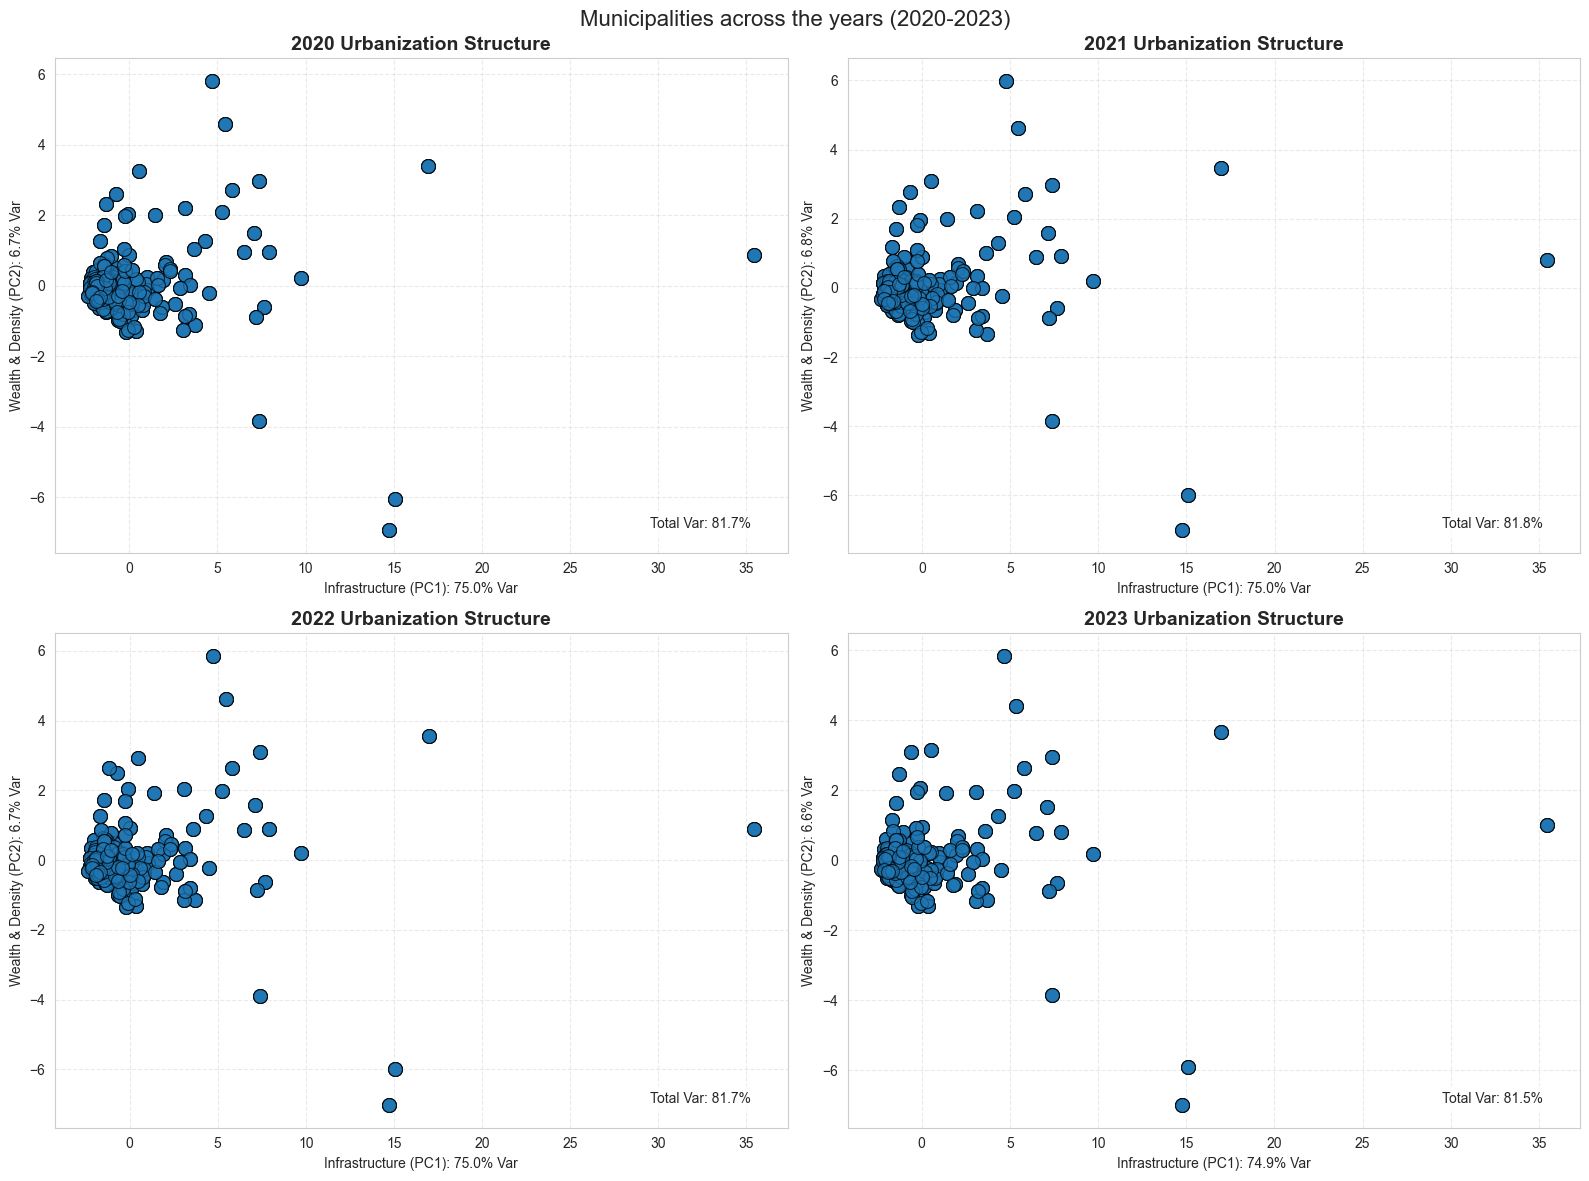

In [52]:
EXP_KEY = "urban"
config = CLUSTERING_CONFIGS[EXP_KEY]

loader = DataLoader(MASTER_DF_FILE)

fig, axes = plt.subplots(2, 2, figsize=(16, 12))
axes = axes.flatten()  # Flatten to make indexing (0, 1, 2, 3) easier

for i, year in enumerate(YEARS):
    ax = axes[i]
    
    try:
        df_year = loader.get_data_for_year(year, features=config["features"])
        
        if df_year.empty:
            ax.text(0.5, 0.5, f"No Data for {year}", ha='center', fontsize=14)
            continue

        analyzer = UrbanizationPCA(n_components=2)
        pca_tmp_df = analyzer.run_pca(df_year)
        stats = analyzer.get_variance_stats()
        
        sns.scatterplot(
            x='PC1', 
            y='PC2', 
            data=pca_tmp_df, 
            ax=ax, 
            s=100, 
            alpha=0.7, 
            edgecolor='k',
            legend=False
        )
        
        ax.set_title(f"{year} Urbanization Structure", fontsize=14, weight='bold')
        ax.set_xlabel(f"Infrastructure (PC1): {stats['pc1_var']:.1f}% Var")
        ax.set_ylabel(f"Wealth & Density (PC2): {stats['pc2_var']:.1f}% Var")
        ax.grid(True, linestyle="--", alpha=0.4)
        
        # Add total variance annotation
        ax.text(0.95, 0.05, f"Total Var: {stats['total_var']:.1f}%", 
                transform=ax.transAxes, ha='right', fontsize=10, 
                bbox=dict(facecolor='white', alpha=0.8))

    except Exception as e:
        ax.text(0.5, 0.5, f"Error: {str(e)}", ha='center', color='red')

fig.suptitle("Municipalities across the years (2020-2023)", fontsize=16)

plt.tight_layout()
plt.show()

Since we've seen that there's no significant difference between years, we'll take the data from 2022 to obtain the clusters. We'll do the clustering with `K-means` in order to get all of the municipalities assigned. For more details, go to [`notebooks/clustering/01_urbanization_clustering_all.ipynb`](notebooks/clustering/01_urbanization_clustering_all.ipynb). 

The optimal number of clusters was estimated with the use of the Elbow method and the Silhouette analysis. Worth mentioning that even though those methods clearly indicated that 3 and 4 might be the best options for the number of clusters, we've decided to go with 6 clusters. The reasoning behind it the _outlier-ish_ behaviour of two major cities, Porto and Lisbon.

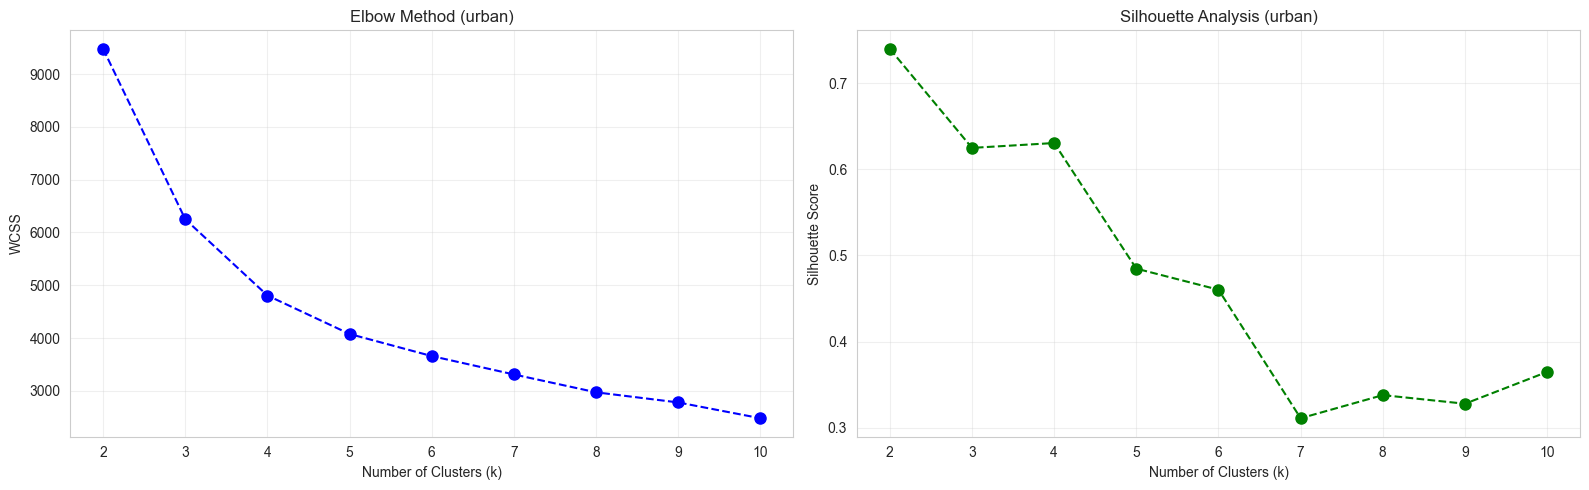

In [53]:
df2022_all = DataLoader(MASTER_DF_FILE).get_data_for_year(year=2022)
pca_engine = UrbanizationPCA(n_components=2)


engine = ClusteringEngine(experiment_name=EXP_KEY, seed=RANDOM_SEED)
engine.load_and_preprocess(df2022_all)
elbow_fig, cluster_df = engine.run_kmeans_tuning()
elbow_fig.show()


After running several experiments, including the one where we treated Porto and Lisbon as outliers ([`notebooks/clustering/02_urbanization_clustering_no_Porto.ipynb`](notebooks/clustering/02_urbanization_clustering_no_Porto.ipynb)), the best (most trustworthy) result was obtained with 6 clusters from the dataset containing all of the municipalities, as shown below.

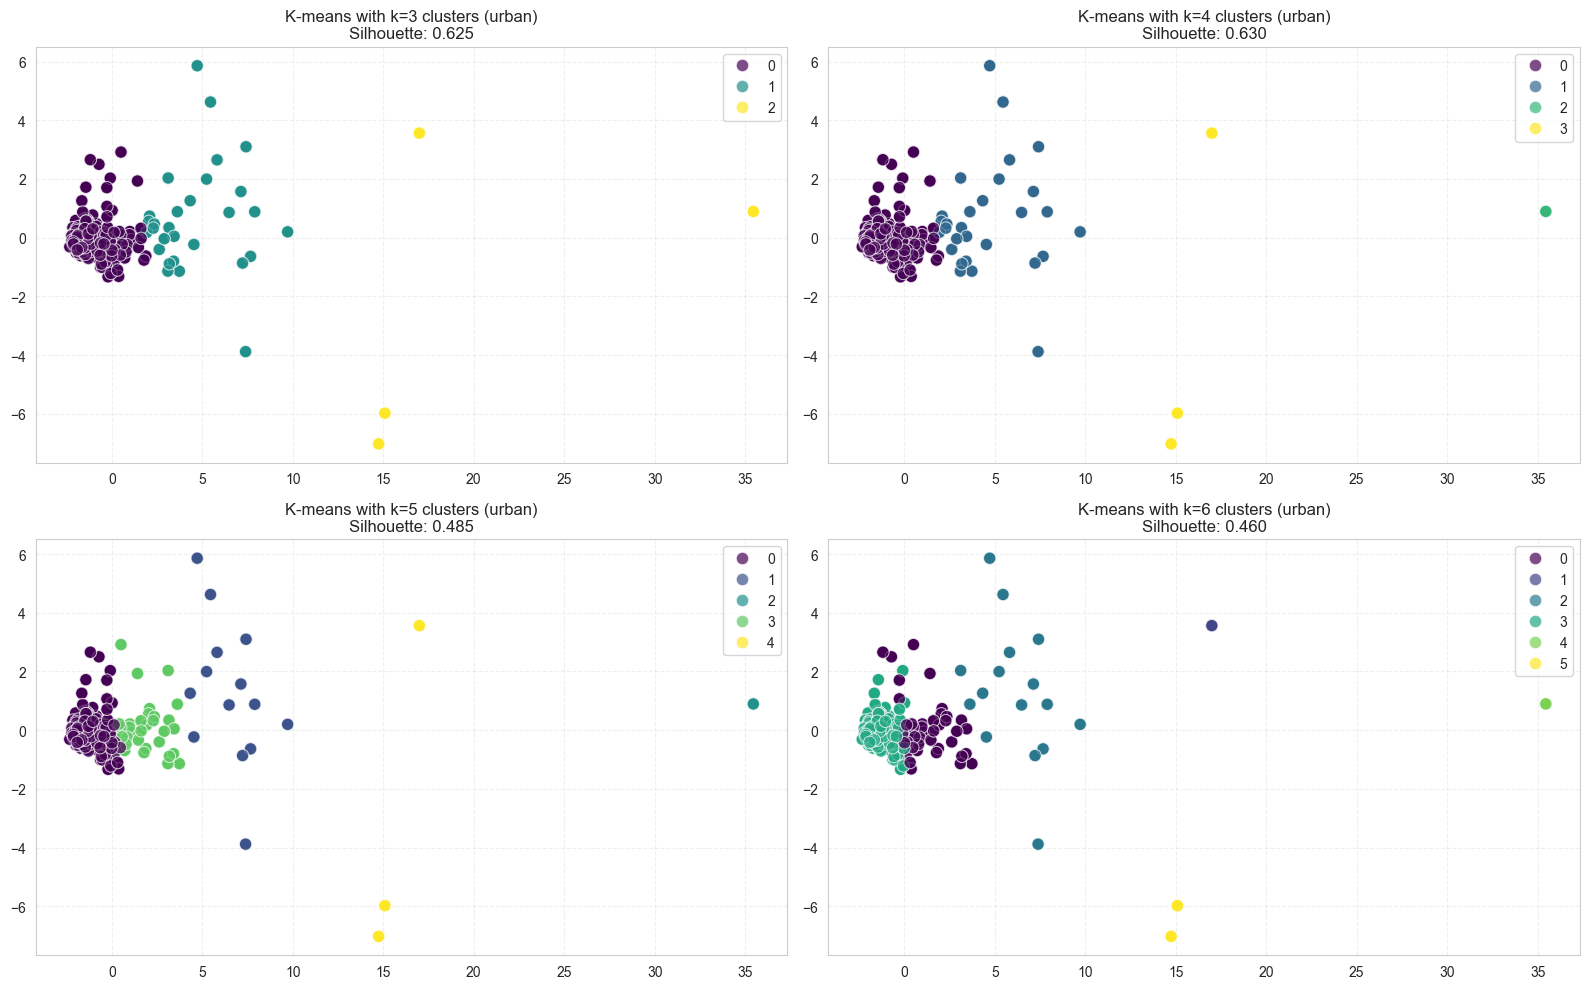

In [54]:
engine.run_batch_training()
df2022_pca = DataLoader(MASTER_DF_FILE).get_data_for_year(year=2022, features=config["features"])
pca_coords = pca_engine.run_pca(df2022_pca).values
fig = engine.plot_saved_models_from_config(pca_data=pca_coords)
fig.show()

As a result of the clustering we've obtained one additional categorical feature, `cluster_urban`. Later on we've decided to run the modeling within the major clusters (Rural, Urban and Suburbs). All of the characteristics of the clusters can be inverstigated in the [`notebooks/clustering/01_urbanization_clustering_all.ipynb`](notebooks/clustering/01_urbanization_clustering_all.ipynb) and [`notebooks/clustering/02_urbanization_clustering_no_Porto.ipynb`](notebooks/clustering/02_urbanization_clustering_no_Porto.ipynb).

We've also conducted the analysis of the age distribution in the obtained clusters. Unfortunately, without additional investigation we didn't come up with any valuable information for the modeling step. Yet the research suggests further questions on the project development. Maybe if we've added a bit more data :)

The age distribution analysis within clusters: [`notebooks/clustering/03_urbanization_age_distribution.ipynb`](notebooks/clustering/03_urbanization_age_distribution.ipynb)

### Modeling

For the modelling part, we decided to use the data from 2019-2022 as training data, and the 2023 data as testing data. The intent was to grasp the real performance of the models and to compare with the baseline models. Based on the first experiment, we decided to keep going with ElasticNet and Gradient Boosting models, since they were the best performing models in their class. This will also allow us to understand how each of the models approaches the problem.


**Results:**

| Where | Model | How accurate? 
|-------|-------|---------------
| Rural | GBM | 83% | Small 
| Rural | ElasticNet | 35% | Big
| Suburbs | GBM | 79% | Smal
| Suburbs | ElasticNet | 72% | M
| Urban | GBM | 72% |
| Urban | ElasticNet | 40% 

**Conclusion:**
Gradient Boosting was the best performance model, because the house prices do not follow simple rules, with features interacting in unexpected ways. This model was capable of capturing that complexity.

>  Full modeling story: [`notebooks/modeling/02_modeling_urban_clusters.ipynb`](notebooks/modeling/02_modeling_urban_clusters.ipynb)

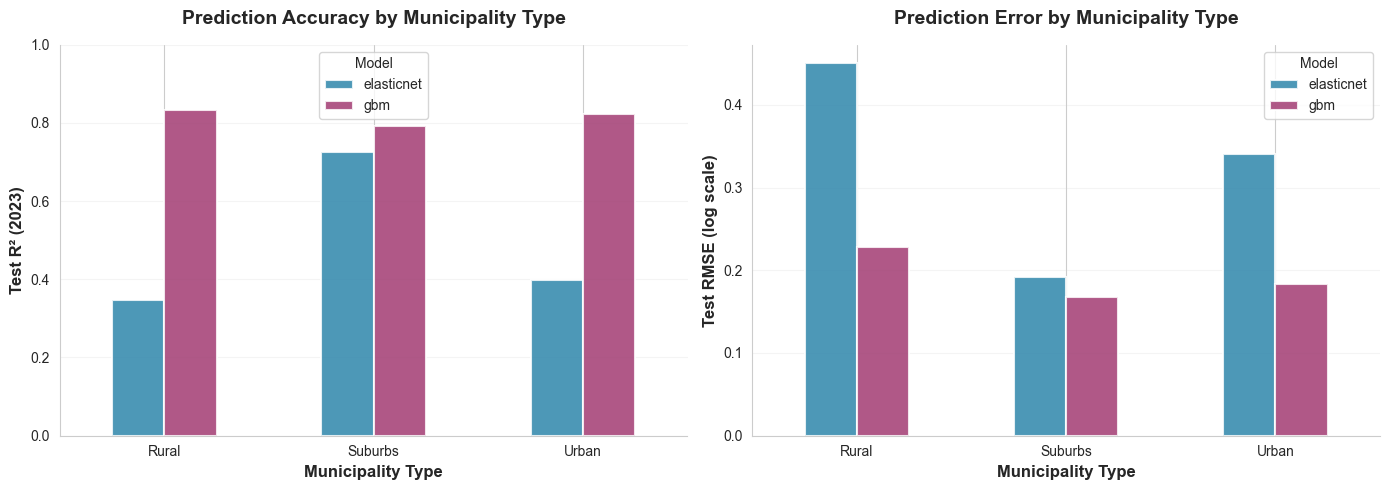

In [55]:
results_df = pd.read_csv(MODELS_DIR / "temporal_validation_by_cluster.csv")
fig, axes = plt.subplots(1, 2, figsize=(14, 5))
fig.patch.set_facecolor('white')

colors = ['#2E86AB', '#A23B72']

pivot_r2 = results_df.pivot(index='Cluster', columns='Model', values='Test R² (2023)')
pivot_r2.plot(kind='bar', ax=axes[0], color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)
axes[0].set_xlabel('Municipality Type', fontsize=12, fontweight='600')
axes[0].set_ylabel('Test R² (2023)', fontsize=12, fontweight='600')
axes[0].set_title('Prediction Accuracy by Municipality Type', fontsize=14, fontweight='bold', pad=15)
axes[0].legend(title='Model', fontsize=10)
axes[0].set_xticklabels(axes[0].get_xticklabels(), rotation=0)
axes[0].grid(True, alpha=0.2, axis='y')
axes[0].set_ylim(0, 1)
sns.despine(ax=axes[0])

pivot_rmse = results_df.pivot(index='Cluster', columns='Model', values='Test RMSE (2023)')
pivot_rmse.plot(kind='bar', ax=axes[1], color=colors, alpha=0.85, edgecolor='white', linewidth=1.5)
axes[1].set_xlabel('Municipality Type', fontsize=12, fontweight='600')
axes[1].set_ylabel('Test RMSE (log scale)', fontsize=12, fontweight='600')
axes[1].set_title('Prediction Error by Municipality Type', fontsize=14, fontweight='bold', pad=15)
axes[1].legend(title='Model', fontsize=10)
axes[1].set_xticklabels(axes[1].get_xticklabels(), rotation=0)
axes[1].grid(True, alpha=0.2, axis='y')
sns.despine(ax=axes[1])

plt.tight_layout()
plt.show()

### Model Results:
This results, clearly show that Gradient Boosting is the best performing model at predicting the house prices, achieving 72-83% accuracy. Also we can see that the Rural areas are easier to predict, compared to more dense areas, and lastly, that the non-linear model is able to capture the complexity of the dataset relationships.

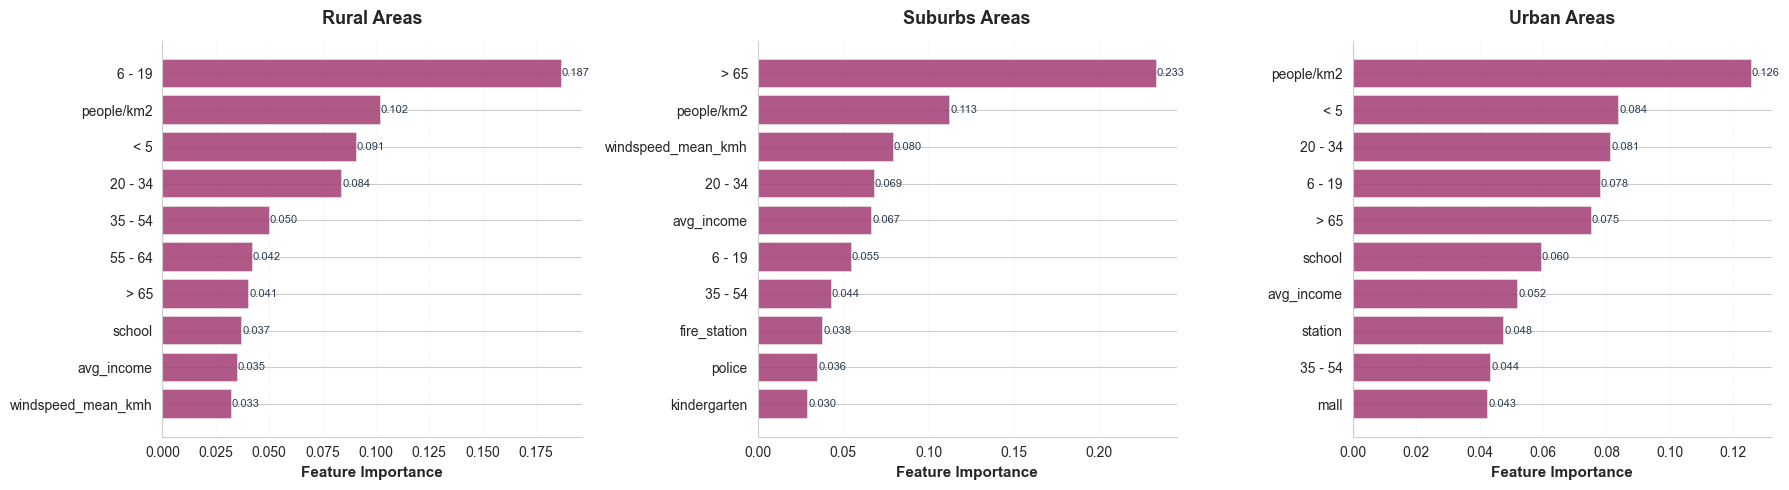

In [56]:
importance_df = pd.read_csv(MODELS_DIR / "feature_importance_by_cluster.csv")

gbm_importance = importance_df[importance_df['Model'] == 'gbm']

fig, axes = plt.subplots(1, 3, figsize=(18, 5))
fig.patch.set_facecolor('white')

clusters = [('Rural', 0), ('Suburbs', 1), ('Urban', 4)]

for idx, (label, cluster_id) in enumerate(clusters):
    cluster_data = gbm_importance[gbm_importance['Cluster ID'] == cluster_id].sort_values(
        'Importance', ascending=False
    ).head(10)
    
    bars = axes[idx].barh(cluster_data['Feature'], cluster_data['Importance'], 
                          color='#A23B72', alpha=0.85, edgecolor='white', linewidth=1.2)
    axes[idx].set_xlabel('Feature Importance', fontsize=11, fontweight='600')
    axes[idx].set_title(f'{label} Areas', fontsize=13, fontweight='bold', pad=12)
    axes[idx].invert_yaxis()
    axes[idx].grid(True, alpha=0.15, axis='x', linestyle='--')
    sns.despine(ax=axes[idx])
    
    for bar in bars:
        width = bar.get_width()
        axes[idx].text(width, bar.get_y() + bar.get_height()/2, 
                      f'{width:.3f}', ha='left', va='center', 
                      fontsize=8, color='#2C3E50', fontweight='500')

plt.tight_layout()
plt.show()

### Key Insights:

 - Rural Areas:
   - Weather conditions dominate
   - Demographics matter
   - Limited infrastructure means natural amenities are valued (e.g. schools)

- Suburbs:
  - Density plays a significant role
  - Higher incomes are more valuable

- Urban Areas:
  - Density plays the biggest role
  - Everyday ameinities are valued (e.g. malls, school, station)

# Conclusion

So we can conclude that the driving factor of house prices, is highly dependable on the location, for example in rural areas the weather is very relevant, but in the other hand, in the urban areas, the population density is the driving factor. 